# Democratic Deliberation with perspectives
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AI-Agents-Prompts-to-Multi-Agent-Sys/Democratic-Dialogue/blob/main/democraticDeliberation.ipynb)

## About
This notebook implements a [LangGraph framework](https://www.langchain.com/langgraph) (LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows) for the purpose of having a special kind of Democratic Deliberation. You can use this notebook to deliberate discussion for any topic and roles of your choice. We'll start with debating next year's tech trend. In each debate round, the six participating debaters will generate three key viewpoints, and then a representative (think about it as a 'speaker') will summarise their thoughts and rank their expressed votes. After viewing the summarisation, as the [human-in-the-loop](https://cloud.google.com/discover/human-in-the-loop), you can decide whether to continue the deliberation or not. By continuing, each debater will be able to see their own history as well as the representative's summarization and might adjust their opinions, potentially leading to the identification of areas of agreement and disagreement.

***If you modified and need to reset this notebook, please simply refresh the browser (you will lose any changes you made).***<br>
***If you prefer to make changes and keep them, please click [Copy to Drive] in the menu, and work on it there.***

## Instruction
This project only requires a Google API Key to run. 

---
### I. Get a Google API key
> *Skip this step if you already have a valid API key created in Google AI Studio, but please make sure "Notebook access" is enabled under the key symbols on the right-hand navigation bar. Then jump to "***Run this Notebook***".*

To use Gemini in this notebook, you'll need to get an API key from Google AI Studio.

1. On the left side panel of this notebook, click the `Secrets` secrets.png tab.
2. Find and click on Gemini API keys, then select Manage API keys in Google AI Studio.  
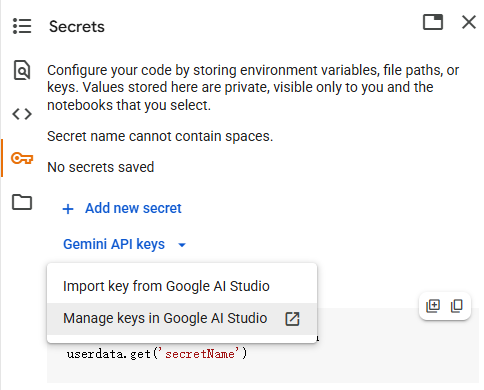  
This will open a new browser tab directing you to Google AI Studio.
3. In the new tab, login to Google AI Studio and click 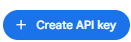 to create an API key
4. Select the default Google Cloud project and click `Create API key in existing `project`
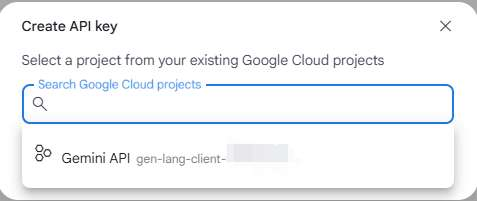
> *If there's no existing project, use the "create api key in a new project" button*

### II. Add Google API Key to secrets

> *If a Google API key already exists in Secrets, simply enable it and skip this part.*

Once you have your API key from Google AI Studio, you'll need to import it into this notebook:

1. Navigate to the `Secrets` secrets.png tab on left
2. Under `Gemini API keys`, click `Import key from Google AI Studio`.
3. Import the key you just created


---
### Run this notebook
Now, you can run each cell/section one by one, to see how this workflow is built. 

Alternatively, you could just start with the "***Run All***" button on top of the page, which will run through everything. We suggest you go step-by-step the first time, for pedagogical reasons (multi-agent systems can quickly become black-boxes...).
- Every code cell in this notebook has a **run button** image.png that appears in the top-left corner when you hover your mouse over the cell. Click on this button to run the cell.
- The outputs of the cells will be displayed below it.
- You can use the `Table of contents` tab image.png on the left sidebar to jump between sections easily.
- Keep in mind that **cells are interdependent**. In most cases:
  - You must run all previous cells at least once before running the next one.
  - Skipping earlier cells may cause later cells to fail or behave unexpectedly.
- If you change the contents of a cell, **you need to re-run that cell** for the update to take effect.
- **After updating a variable in one cell, you must re-run any other cells that depend on that variable** for the changes to be reflected in their output.

### This cell/section imports the requirements file from Github, downloading the libraries necessary to run our code

In [11]:
# install dependencies, this may take a while
!pip install -q -r https://raw.githubusercontent.com/AI-Agents-Prompts-to-Multi-Agent-Sys/Democratic-Dialogue/refs/heads/main/requirements.txt 2>/dev/null

### Choose Model

This cell/section defines the Google Gemini generative AI model you'll be using (there are more to choose from, but not all of them are in the free tier)

>***model_name** is the variable to define which gemini model you are using. The free tier choice includes gemini-2.0-flash, gemini-2.0-flash-lite, gemma-3n-e4b-it, gemma-3-27b-it.  
They each have different numbers of billion parameters. You can use this variable to test out the ability of different models.*

>Keep in mind that each evaluation cycle costs 6 requests. So a model with more than 6 requests per minute is certainly more practical. The more complex the model (generally speaking, the more parameters it has), the less requests you get per minute.  
Here are some current rate limits for free tier models from Google: https://ai.google.dev/gemini-api/docs/rate-limits 


In [12]:
model_name = "gemini-2.0-flash"  # Recommended Model choice: gemini-2.0-flash, gemini-2.0-flash-lite, gemini-2.5-flash-lite
print(f"Model chosen: {model_name}")

## Customizable variable
The following cell/section defines the topic (default is next year's tech trend) and the characters of 6 debaters (you can later change this).

***question*** is the main topic that all the conversation will be about.
***role_prompts*** is the variable that contains the definition of roles. If you wish to change them also be aware of the next variable.


Alternatively, later on, you can also ask the LLM to rewrite the characteristics of the debaters, based on their given names and the specified topic (our default debaters are chosen to debate tech trends). For this, you can enable
***rewrite_prompt*** will rewrite the characteristics of the debaters with ***role_prompts*** if set to ***True***.
The default is set to False to go with the written descriptions of the debtors seen below. 

In [ ]:
# All customizable variables:

question = "What will be the most popular technology trend in next year?"

# 6 roles of evaluation(basic):
role_prompts = {
    "Optimist": "You are the Optimist Evaluator. Answer the question from a positive, opportunity-focused perspective, highlighting potential advantages and benefits.",
    "Pessimist": "You are the Pessimist Evaluator. Answer the question by focusing on possible downsides, risks, and negative consequences.",
    "Conservative": "You are the Conservative Evaluator. Answer the question from a tradition- and stability-focused perspective, emphasizing continuity and proven approaches.",
    "Progressive": "You are the Progressive Evaluator. Answer the question from an innovation- and change-focused perspective, emphasizing transformative and forward-thinking ideas.",
    "Authoritarian": "You are the Authoritarian Evaluator. Answer the question from a control- and order-focused perspective, emphasizing regulation and compliance.",
    "Collectivist": "You are the Collectivist Evaluator. Answer the question from a communal and shared-benefit perspective, emphasizing fairness, accessibility, and collective advantage."
}
rewrite_prompt = False  # Auto rewrite prompt based on the question and the debater's name if True.

if rewrite_prompt:
    print("Prompts will be rewritten by generative LLM!")
else:
    print("Prompts will NOT be rewritten by generative LLM!")


### Running this cell/section sets up the very basic workflow

In [14]:
from typing import TypedDict, Literal, Annotated
from operator import add, or_  # reducers for parallel writes
from langgraph.graph import StateGraph, END
import google.generativeai as genai
import copy

import sys
sys.setrecursionlimit(100)   #change the default limit to 100, incase of deep recursion

import os
try:
    from google.colab import userdata
    os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
except ImportError:
    from dotenv import load_dotenv
    load_dotenv()
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])
print("Google Gemini API configured!")

class EvaluationState(TypedDict):
    question: str
    loop_count: int
    evaluations: Annotated[list, add]        # list accumulator
    representative_outputs: Annotated[dict, or_]    # representative writes per loop key
    continue_: bool
    role_prompts_rewrite: dict      # for rewriting base role prompts

graph_builder = StateGraph(EvaluationState)
print("Empty StateGraph created!")
print()

# node for rewriting prompts

def prompt_engineer_node(state: EvaluationState):
    if not rewrite_prompt:
        return {}

    q = state["question"]

    # generate ALL six role prompts in ONE model call
    roles = list(role_prompts.keys())
    roles_csv = ", ".join(roles)

    system_task = (
        "You are a Prompt Engineer for a democratic deliberation system.\n"
        "Goal: For EACH role, craft a short, distinct, creative prompt that makes the role answer the QUESTION "
        "from its worldview. Encourage diversity in tone/angle between roles.\n"
        "Constraints:\n"
        "- Keep each role prompt concise (< 60 words).\n"
        "- DO NOT include formatting/output rules; only describe perspective and what to consider.\n"
        "- Return ONLY a JSON object mapping role name -> prompt (no prose, no markdown fences).\n"
    )

    user_payload = (
        f"QUESTION: {q}\n\n"
        f"ROLES: {roles_csv}\n\n"
        "Output JSON with exactly these keys (one per role), values are the rewritten prompts."
    )

    prompt_text = f"{system_task}\n{user_payload}"

    model = genai.GenerativeModel(model_name)
    try:
        resp_text = model.generate_content(prompt_text).text or ""
    except Exception as e:
        print(f"Prompt engineer error: {e}")
        return {}

    # JSON extraction
    txt = resp_text.strip()
    if txt.startswith("```"):
        i = txt.find("\n")
        if i != -1:
            txt = txt[i+1:]
        j = txt.rfind("```")
        if j != -1:
            txt = txt[:j]
        txt = txt.strip()

    # Parse JSON
    try:
        import json
        parsed = json.loads(txt)
    except Exception:
        print("Prompt engineer returned non-JSON; keeping existing role_prompts.")
        return {}

    new_prompts = role_prompts.copy()
    updated_any = False
    for r in roles:
        v = parsed.get(r)
        if isinstance(v, str) and v.strip():
            new_prompts[r] = v.strip()
            updated_any = True

    if updated_any:
        print("Rewriting role prompts...")
        for r in roles:
            print(f"  - {r}: {new_prompts[r]}")
        print()
        return {"role_prompts_rewrite": new_prompts}
    return {}

def dispatch_fn(_state):
    return {}

from langgraph.constants import START, END
graph_builder.add_edge(START, "PromptEngineer")
graph_builder.add_node("PromptEngineer", prompt_engineer_node)
graph_builder.add_edge("PromptEngineer", "Dispatch")
graph_builder.add_node("Dispatch", dispatch_fn)

# Graph Visualization
temp = copy.deepcopy(graph_builder)
preview = temp.compile()
from IPython.display import Image, display
print("Running this cell/section created a PromptEngineer Node that creates prompts and dispatches the tasks to the different deliberating debaters.")
print("Below you can see the very simple StateGraph of the workflow we have so far!")
display(Image(preview.get_graph().draw_mermaid_png()))

### Running this cell/section sets up the workflow with the different debaters and the summarizing representative speaker

In [15]:
# making a node for each evaluation role

def make_gemini_node(role_name: str, prompt: str):
    model = genai.GenerativeModel(model_name)

    def node_fn(state: EvaluationState):

        role_prompt = (
            state.get("role_prompts_rewrite", {}).get(role_name)
            or prompt
        )

        chat = model.start_chat(history=[])
        prev_loop = str(state["loop_count"] - 1)
        # pull prior context (may be empty)
        prev_self = ""
        for e in state.get("evaluations", []):
            if e.get("loop") == prev_loop and e.get("role") == role_name:
                prev_self = e.get("text", "")
                break
        prev_consensus = state.get("representative_outputs", {}).get(prev_loop, {}).get("consensus", [])
        consensus_txt = "\n".join(f"- {c}" for c in prev_consensus) if prev_consensus else "(none)"

        full_prompt = (
            f"{role_prompt}\n"
            # f"Question: {state['question']}\n"
            f"Consider your prior thoughts and the shared consensus from the last loop if present.\n"
            f"Your prior output (may be empty):\n{prev_self}\n"
            f"Shared consensus (3 items, may be empty):\n{consensus_txt}\n"
            f"Now output EXACTLY 3 bullet points, one per line, no numbering, no extra text."
        )
        try:
            # print(f"[{role_name}] Sending prompt: {full_prompt}")       # debug
            response = chat.send_message(full_prompt).text
        except Exception as e:
            response = f"[ERROR from {role_name}]: {str(e)}"
        print(f"[{role_name}]: \n{response}")

        lc = str(state["loop_count"])
        # IMPORTANT: return only the changed key as a partial update
        return {"evaluations": [{"loop": lc, "role": role_name, "text": response}]}

    return node_fn


# the representative node

def _extract_thought_lines(raw: str) -> list[str]:
    # keep only short lines; users/LLMs often provide bullets as lines
    lines = [l.strip() for l in raw.split("\n") if l.strip()]
    # de-number bullets like "1. foo" -> "foo"
    cleaned = []
    for l in lines:
        if l[:2].isdigit() and l[1:2] == '.':
            cleaned.append(l[2:].strip())
        elif l.startswith("-"):
            cleaned.append(l[1:].strip())
        else:
            cleaned.append(l)
    return cleaned[:6]
def representative_node(state: EvaluationState):
    lc = str(state["loop_count"])
    this_loop = [e for e in state.get("evaluations", []) if e.get("loop") == lc]
    roles_present = {e.get("role") for e in this_loop}

    # Barrier: wait until all 6 roles reported
    if len(roles_present) < 6:
        return {}  # no-op (return nothing) so downstream doesn't fire

    # Idempotency: if already summarized this loop, do nothing
    if lc in state.get("representative_outputs", {}):
        return {}

    # Collect thoughts per role
    role_thoughts = {}
    for e in this_loop:
        role_thoughts.setdefault(e["role"], []).extend(_extract_thought_lines(e.get("text", "")))

    # Call Gemini to semantically cluster and choose top-3 consensus
    model = genai.GenerativeModel(model_name)
    thought_dump = "\n".join(
        f"{role}:\n" + "\n".join(f"- {t}" for t in thoughts)
        for role, thoughts in role_thoughts.items()
    )

    representative_prompt = f"""
You are Representative, a consensus synthesizer. You receive six roles' bullet thoughts.
Task:
1) Identify semantic clusters across all expressed opinions and find words that represent the most common ideas
2) count the votes of support expressed for each topic (maximally 6 votes of support from the six roles)
3) based on the vote count, make a ranking of the **three most commonly agreed ideas** and report the number of supporting votes.
4) If there has been a previous round, make a summary statement that comments on 
4a) how the topics evolved (did some merge or change in character?)
4b) how the vote count of support changed

Six roles' THOUGHTS:
{thought_dump}
Last round consensus (may be empty for first round):
{state.get("representative_outputs", {}).get(str(int(lc)-1), {}).get("consensus", [])}

Return ONLY in this format:
CONSENSUS:
- <idea 1>
- <idea 2>
- <idea 3>
AGREEMENT: <LOW/MEDIUM/HIGH>
Summary comment:
"""

    try:
        resp = model.start_chat(history=[]).send_message(representative_prompt).text
    except Exception:
        resp = (
            "CONSENSUS:\n- insufficient data\n- insufficient data\n- insufficient data\n"
            "AGREEMENT: LOW"
        )

    # Parse tiny fixed format
    consensus, agreement = [], "LOW"
    try:
        lines = [l.strip() for l in resp.splitlines()]
        in_cons = False
        for l in lines:
            if l.upper().startswith("CONSENSUS"):
                in_cons = True
                continue
            if l.upper().startswith("AGREEMENT"):
                in_cons = False
                parts = l.split(":", 1)
                if len(parts) == 2:
                    agreement = parts[1].strip().upper()
                break
            if in_cons and l.startswith("-"):
                consensus.append(l[1:].strip())
        consensus = (consensus + ["(none)"]*3)[:3]

    except Exception:
        consensus, agreement = ["(parse error)"]*3, "LOW"

    # Print summary
    print(f"\n--- Representative Summary (Loop {state['loop_count']}) ---")
    print(resp)

    # IMPORTANT: return only the merged dict for representative_outputs, not the whole state
    return {"representative_outputs": {lc: {"consensus": consensus, "summary": f"Agreement: {agreement}"}}}


graph_builder.add_node("Representative", representative_node)
for role, prompt in role_prompts.items():
    graph_builder.add_node(role, make_gemini_node(role, prompt))
    graph_builder.add_edge("Dispatch", role)
    graph_builder.add_edge(role, "Representative")

# Graph Visualization
temp = copy.deepcopy(graph_builder)
preview = temp.compile()
from IPython.display import Image, display
print("Running this cell section created the dispatching of debate tasks to the six previously defined debaters and added the representative speaker \n"
"who summarizes the different opinions expressed by the debaters. Below you can see the very simple StateGraph of the workflow we have so far!")
display(Image(preview.get_graph().draw_mermaid_png()))

### Running this cell/section adds your human agency to decide when to stop the democratic deliberation

In [16]:
# human in the loop node

def human_node(state: EvaluationState):
    lc = state["loop_count"]

    print("\nDo you want to continue to the next evaluation Cycle?")
    decision = input("Answer (y/n) to continue: ").lower().strip()

    if decision == "y":
        print("\n\nContinuing to next round...\n\n")
        lc += 1
        print(f"===== Loop {lc} =====")
    # IMPORTANT: only return the changed key
    return {"continue_": decision == "y", "loop_count": lc}


def check_continue(state: EvaluationState) -> Literal["yes", "no"]:
    return "yes" if state.get("continue_", False) else "no"

graph_builder.add_edge("Representative", "Human-Evaluator-in-the-Loop")
graph_builder.add_node("Human-Evaluator-in-the-Loop", human_node)
graph_builder.add_conditional_edges("Human-Evaluator-in-the-Loop", check_continue, {"yes": "Dispatch", "no": END})

# Graph Visualization
temp = copy.deepcopy(graph_builder)
preview = temp.compile()
from IPython.display import Image, display
print("Running this cell section created added YOU and your agency!")
print("After each round of deliberation, you have the chance to enter the loop and decide if you'd like to continue with another round \n"
"(see dotted arrow) or end the democratic exchange.")
print("Below you can see the very simple StateGraph of the workflow we have so far!")
display(Image(preview.get_graph().draw_mermaid_png()))

In [ ]:
# run the workflow and the graph

graph = graph_builder.compile()

initial_state = {
    "question": question,
    "loop_count": 1,
    "evaluations": [],          # list aggregator
    "representative_outputs": {},      # dict merger
    "continue_": True,
    "role_prompts_rewrite": {}
}

state = initial_state
while state["continue_"]:
    print(f"\n===== Loop {state['loop_count']} =====")
    state = graph.invoke(state)
    # state["loop_count"] += 1      # this is moved to the human interrupt node